#### NOTE: 

This notebook is an updated version of the notebook used in the **hands-on lecture**.

The following changes have been made:

1. solver hyperparameter set to 'liblinear'

    * In the video, the professor used the default 'lbfgs' solver in Logistic Regression model but after an update in the sklearn,the default solver 'lbfgs' gives certain errors. To avoid any errors, the solver has been set to 'liblinear', this will result in small change in the values of metrics of the model as compared to the hands-on video.

# Ensemble Hands On - Bagging

We are going to build a model that predicts if someone who seeks a loan might be a defaulter or a non-defaulter. We have several independent variables like, checking account balance, credit history, purpose, loan amount etc.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

**We will use the same `credit data` used in decision tree hands-on lecture.**

In [2]:
url = "credit.csv"
creditData = pd.read_csv(url)

#creditData = pd.read_csv("credit.csv")
creditData.head(10) #several missing values!

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,other_credit,housing,existing_loans_count,job,dependents,phone,default
0,< 0 DM,6,critical,furniture/appliances,1169,unknown,> 7 years,4,4,67,none,own,2,skilled,1,yes,no
1,1 - 200 DM,48,good,furniture/appliances,5951,< 100 DM,1 - 4 years,2,2,22,none,own,1,skilled,1,no,yes
2,unknown,12,critical,education,2096,< 100 DM,4 - 7 years,2,3,49,none,own,1,unskilled,2,no,no
3,< 0 DM,42,good,furniture/appliances,7882,< 100 DM,4 - 7 years,2,4,45,none,other,1,skilled,2,no,no
4,< 0 DM,24,poor,car,4870,< 100 DM,1 - 4 years,3,4,53,none,other,2,skilled,2,no,yes
5,unknown,36,good,education,9055,unknown,1 - 4 years,2,4,35,none,other,1,unskilled,2,yes,no
6,unknown,24,good,furniture/appliances,2835,500 - 1000 DM,> 7 years,3,4,53,none,own,1,skilled,1,no,no
7,1 - 200 DM,36,good,car,6948,< 100 DM,1 - 4 years,2,2,35,none,rent,1,management,1,yes,no
8,unknown,12,good,furniture/appliances,3059,> 1000 DM,4 - 7 years,2,4,61,none,own,1,unskilled,1,no,no
9,1 - 200 DM,30,critical,car,5234,< 100 DM,unemployed,4,2,28,none,own,2,management,1,no,yes


In [3]:
creditData.shape

(1000, 17)

In [4]:
creditData['default'].value_counts()

no     700
yes    300
Name: default, dtype: int64

In [5]:
creditData.describe()

,months_loan_duration,amount,percent_of_income,years_at_residence,age,existing_loans_count,dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


In [6]:
creditData.info()  # many columns are of type object i.e. strings. These need to be converted to ordinal type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   checking_balance      1000 non-null   object
 1   months_loan_duration  1000 non-null   int64 
 2   credit_history        1000 non-null   object
 3   purpose               1000 non-null   object
 4   amount                1000 non-null   int64 
 5   savings_balance       1000 non-null   object
 6   employment_duration   1000 non-null   object
 7   percent_of_income     1000 non-null   int64 
 8   years_at_residence    1000 non-null   int64 
 9   age                   1000 non-null   int64 
 10  other_credit          1000 non-null   object
 11  housing               1000 non-null   object
 12  existing_loans_count  1000 non-null   int64 
 13  job                   1000 non-null   object
 14  dependents            1000 non-null   int64 
 15  phone                 1000 non-null   o

Lets convert the columns with an 'object' datatype into categorical variables

In [7]:
for feature in creditData.columns: # Loop through all columns in the dataframe
    if creditData[feature].dtype == 'object': # Only apply for columns with categorical strings
        creditData[feature] = pd.Categorical(creditData[feature])# Replace strings with an integer
creditData.head(10)

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,other_credit,housing,existing_loans_count,job,dependents,phone,default
0,< 0 DM,6,critical,furniture/appliances,1169,unknown,> 7 years,4,4,67,none,own,2,skilled,1,yes,no
1,1 - 200 DM,48,good,furniture/appliances,5951,< 100 DM,1 - 4 years,2,2,22,none,own,1,skilled,1,no,yes
2,unknown,12,critical,education,2096,< 100 DM,4 - 7 years,2,3,49,none,own,1,unskilled,2,no,no
3,< 0 DM,42,good,furniture/appliances,7882,< 100 DM,4 - 7 years,2,4,45,none,other,1,skilled,2,no,no
4,< 0 DM,24,poor,car,4870,< 100 DM,1 - 4 years,3,4,53,none,other,2,skilled,2,no,yes
5,unknown,36,good,education,9055,unknown,1 - 4 years,2,4,35,none,other,1,unskilled,2,yes,no
6,unknown,24,good,furniture/appliances,2835,500 - 1000 DM,> 7 years,3,4,53,none,own,1,skilled,1,no,no
7,1 - 200 DM,36,good,car,6948,< 100 DM,1 - 4 years,2,2,35,none,rent,1,management,1,yes,no
8,unknown,12,good,furniture/appliances,3059,> 1000 DM,4 - 7 years,2,4,61,none,own,1,unskilled,1,no,no
9,1 - 200 DM,30,critical,car,5234,< 100 DM,unemployed,4,2,28,none,own,2,management,1,no,yes


In [8]:
print(creditData.checking_balance.value_counts())
print(creditData.credit_history.value_counts())
print(creditData.purpose.value_counts())
print(creditData.savings_balance.value_counts())
print(creditData.employment_duration.value_counts())
print(creditData.other_credit.value_counts())
print(creditData.housing.value_counts())
print(creditData.job.value_counts())
print(creditData.phone.value_counts())


unknown       394
< 0 DM        274
1 - 200 DM    269
> 200 DM       63
Name: checking_balance, dtype: int64
good         530
critical     293
poor          88
very good     49
perfect       40
Name: credit_history, dtype: int64
furniture/appliances    473
car                     337
business                 97
education                59
renovations              22
car0                     12
Name: purpose, dtype: int64
< 100 DM         603
unknown          183
100 - 500 DM     103
500 - 1000 DM     63
> 1000 DM         48
Name: savings_balance, dtype: int64
1 - 4 years    339
> 7 years      253
4 - 7 years    174
< 1 year       172
unemployed      62
Name: employment_duration, dtype: int64
none     814
bank     139
store     47
Name: other_credit, dtype: int64
own      713
rent     179
other    108
Name: housing, dtype: int64
skilled       630
unskilled     200
management    148
unemployed     22
Name: job, dtype: int64
no     596
yes    404
Name: phone, dtype: int64


In [9]:
replaceStruct = {
                "checking_balance":     {"< 0 DM": 1, "1 - 200 DM": 2 ,"> 200 DM": 3 ,"unknown":-1},
                "credit_history": {"critical": 1, "poor":2 , "good": 3, "very good": 4,"perfect": 5},
                 "savings_balance": {"< 100 DM": 1, "100 - 500 DM":2 , "500 - 1000 DM": 3, "> 1000 DM": 4,"unknown": -1},
                 "employment_duration":     {"unemployed": 1, "< 1 year": 2 ,"1 - 4 years": 3 ,"4 - 7 years": 4 ,"> 7 years": 5},
                "phone":     {"no": 1, "yes": 2 },
                #"job":     {"unemployed": 1, "unskilled": 2, "skilled": 3, "management": 4 },
                "default":     {"no": 0, "yes": 1 } 
                    }
oneHotCols=["purpose","housing","other_credit","job"]


In [10]:
creditData=creditData.replace(replaceStruct)
creditData=pd.get_dummies(creditData, columns=oneHotCols)
creditData.head(10)


,checking_balance,months_loan_duration,credit_history,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,existing_loans_count,...,housing_other,housing_own,housing_rent,other_credit_bank,other_credit_none,other_credit_store,job_management,job_skilled,job_unemployed,job_unskilled
0,1,6,1,1169,-1,5,4,4,67,2,...,0,1,0,0,1,0,0,1,0,0
1,2,48,3,5951,1,3,2,2,22,1,...,0,1,0,0,1,0,0,1,0,0
2,-1,12,1,2096,1,4,2,3,49,1,...,0,1,0,0,1,0,0,0,0,1
3,1,42,3,7882,1,4,2,4,45,1,...,1,0,0,0,1,0,0,1,0,0
4,1,24,2,4870,1,3,3,4,53,2,...,1,0,0,0,1,0,0,1,0,0
5,-1,36,3,9055,-1,3,2,4,35,1,...,1,0,0,0,1,0,0,0,0,1
6,-1,24,3,2835,3,5,3,4,53,1,...,0,1,0,0,1,0,0,1,0,0
7,2,36,3,6948,1,3,2,2,35,1,...,0,0,1,0,1,0,1,0,0,0
8,-1,12,3,3059,4,4,2,4,61,1,...,0,1,0,0,1,0,0,0,0,1
9,2,30,1,5234,1,1,4,2,28,2,...,0,1,0,0,1,0,1,0,0,0


In [11]:
creditData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   checking_balance              1000 non-null   int64
 1   months_loan_duration          1000 non-null   int64
 2   credit_history                1000 non-null   int64
 3   amount                        1000 non-null   int64
 4   savings_balance               1000 non-null   int64
 5   employment_duration           1000 non-null   int64
 6   percent_of_income             1000 non-null   int64
 7   years_at_residence            1000 non-null   int64
 8   age                           1000 non-null   int64
 9   existing_loans_count          1000 non-null   int64
 10  dependents                    1000 non-null   int64
 11  phone                         1000 non-null   int64
 12  default                       1000 non-null   int64
 13  purpose_business              1000

## Split the data into train and test sets

- When data (classification) exhibit a significant imbalance in the distribution of the target classes, it is good to use stratified sampling to ensure that relative class frequencies are approximately preserved in train and test sets. 
- This is done by setting the `stratify` parameter to target variable in the train_test_split function.

In [12]:
X = creditData.drop("default" , axis=1)
y = creditData.pop("default")

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=1,stratify=y)

**Before building the model, let's create functions to calculate different metrics- Accuracy, Recall and Precision and plot the confusion matrix.**

In [14]:
## Function to create confusion matrix
def make_confusion_matrix(model,y_actual,labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    
    '''
    y_predict = model.predict(X_test)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [15]:
##  Function to calculate different metric scores of the model - Accuracy, Recall and Precision
def get_metrics_score(model,flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    score_list=[] 
    
    #Predicting on train and tests
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    #Accuracy of the model
    train_acc = model.score(X_train,y_train)
    test_acc = model.score(X_test,y_test)
    
    #Recall of the model
    train_recall = metrics.recall_score(y_train,pred_train)
    test_recall = metrics.recall_score(y_test,pred_test)
    
    #Precision of the model
    train_precision = metrics.precision_score(y_train,pred_train)
    test_precision = metrics.precision_score(y_test,pred_test)
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision))
        
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 
        print("Accuracy on training set : ",model.score(X_train,y_train))
        print("Accuracy on test set : ",model.score(X_test,y_test))
        print("Recall on training set : ",metrics.recall_score(y_train,pred_train))
        print("Recall on test set : ",metrics.recall_score(y_test,pred_test))
        print("Precision on training set : ",metrics.precision_score(y_train,pred_train))
        print("Precision on test set : ",metrics.precision_score(y_test,pred_test))
    
    return score_list # returning the list with train and test scores

## Building the model
- We are going to build 2 ensemble models here - Bagging Classifier and Random Forest Classifier.
- First, let's build these models with default parameters and then use hyperparameter tuning to optimize the model performance.
- We will calculate all three metrics - Accuracy, Precision and Recall but the metric of interest here is recall.
- `Recall` - It gives the ratio of True positives to Actual positives, so high Recall implies low false negatives, i.e. low chances of predicting a defaulter as non defaulter

### Bagging Classifier

In [16]:
#base_estimator for bagging classifier is a decision tree by default
bagging_estimator=BaggingClassifier(random_state=1)
bagging_estimator.fit(X_train,y_train)

BaggingClassifier(random_state=1)

In [17]:
#Using above defined function to get accuracy, recall and precision on train and test set
bagging_estimator_score=get_metrics_score(bagging_estimator)

Accuracy on training set :  0.9814285714285714
Accuracy on test set :  0.7433333333333333
Recall on training set :  0.9428571428571428
Recall on test set :  0.4777777777777778
Precision on training set :  0.9949748743718593
Precision on test set :  0.589041095890411


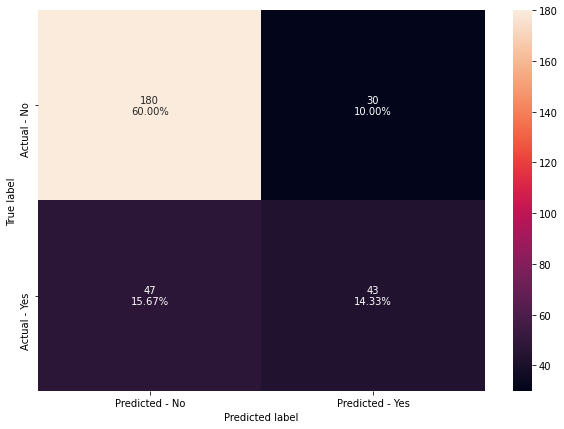

In [18]:
make_confusion_matrix(bagging_estimator,y_test)

### Random Forest Classifier

In [19]:
#Train the random forest classifier
rf_estimator=RandomForestClassifier(random_state=1)
rf_estimator.fit(X_train,y_train)

RandomForestClassifier(random_state=1)

In [20]:
#Using above defined function to get accuracy, recall and precision on train and test set
rf_estimator_score=get_metrics_score(rf_estimator)

Accuracy on training set :  1.0
Accuracy on test set :  0.7533333333333333
Recall on training set :  1.0
Recall on test set :  0.4222222222222222
Precision on training set :  1.0
Precision on test set :  0.6333333333333333


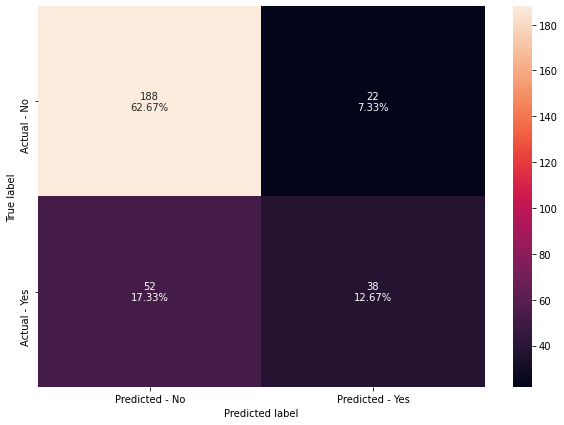

In [21]:
make_confusion_matrix(rf_estimator,y_test)

**With default parameters:**

- Both models - Bagging classifiers as well as random forest classifier are overfitting the train data.
- Both models are giving similar performance in terms of accuracy but bagging classifier is giving better recall.

## Hyperparameter Tuning

### Bagging Classifier

**Some of the important hyperparameters available for bagging classifier are:**

- base_estimator: The base estimator to fit on random subsets of the dataset. If None(default), then the base estimator is a decision tree.
- n_estimators: The number of trees in the forest, default = 100.
- max_features: The number of features to consider when looking for the best split. 
- bootstrap: Whether bootstrap samples are used when building trees. If False, the entire dataset is used to build each tree, default=True.
- bootstrap_features: If it is true, then features are drawn with replacement. Default value is False.
- max_samples: If bootstrap is True, then the number of samples to draw from X to train each base estimator. If None (default), then draw N samples, where N is the number of observations in the train data.
- oob_score: Whether to use out-of-bag samples to estimate the generalization accuracy, default=False.

In [22]:
# Choose the type of classifier. 
bagging_estimator_tuned = BaggingClassifier(random_state=1)

# Grid of parameters to choose from
## add from article
parameters = {'max_samples': [0.7,0.8,0.9,1], 
              'max_features': [0.7,0.8,0.9,1],
              'n_estimators' : [10,20,30,40,50],
             }

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(bagging_estimator_tuned, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
bagging_estimator_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
bagging_estimator_tuned.fit(X_train, y_train)

BaggingClassifier(max_features=0.9, max_samples=0.8, n_estimators=40,
                  random_state=1)

**Let's check different metrics for bagging classifier with best hyperparameters and build a confusion matrix.**

In [23]:
#Using above defined function to get accuracy, recall and precision on train and test set
bagging_estimator_tuned_score=get_metrics_score(bagging_estimator_tuned)

Accuracy on training set :  0.9885714285714285
Accuracy on test set :  0.7533333333333333
Recall on training set :  0.9619047619047619
Recall on test set :  0.45555555555555555
Precision on training set :  1.0
Precision on test set :  0.6212121212121212


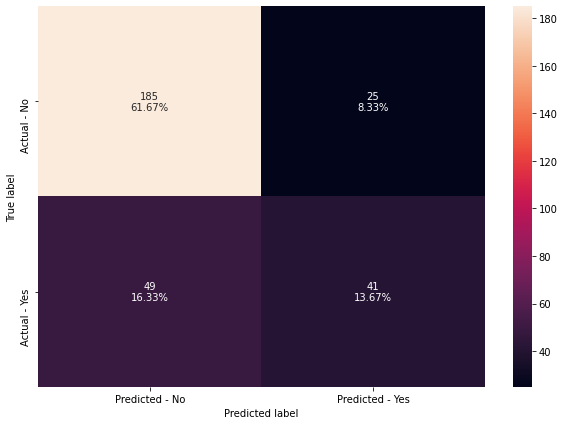

In [24]:
make_confusion_matrix(bagging_estimator_tuned,y_test)

### Insights
- We can see that train accuracy and recall for the bagging classifier have increased slightly after hyperparameter tuning but the test recall has decreased.
- The model is overfitting the data, as train accuracy and recall are much higher than the test accuracy and test recall.
- The confusion matrix shows that the model is better at identifying non-defaulters as compared to defaulters.

### Let's try using logistic regression as the base estimator for bagging classifier:
- Now, let's try and change the `base_estimator` of the bagging classifier, which is a decision tree by default.
- We will pass the logistic regression as the base estimator for bagging classifier.

In [25]:
bagging_lr=BaggingClassifier(base_estimator=LogisticRegression(solver='liblinear',random_state=1,max_iter=1000),random_state=1)
bagging_lr.fit(X_train,y_train)

BaggingClassifier(base_estimator=LogisticRegression(max_iter=1000,
                                                    random_state=1,
                                                    solver='liblinear'),
                  random_state=1)

In [26]:
#Using above defined function to get accuracy, recall and precision on train and test set
bagging_lr_score=get_metrics_score(bagging_lr)

Accuracy on training set :  0.7385714285714285
Accuracy on test set :  0.7166666666666667
Recall on training set :  0.3333333333333333
Recall on test set :  0.35555555555555557
Precision on training set :  0.6194690265486725
Precision on test set :  0.5423728813559322


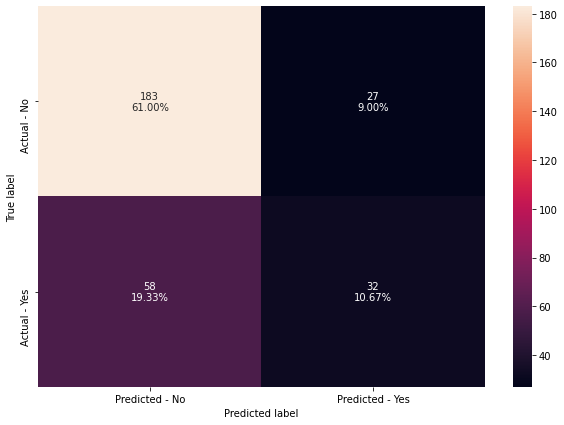

In [27]:
make_confusion_matrix(bagging_lr,y_test)

### Insights
- Bagging classifier with logistic regression as base_estimator is not overfitting the data but the test recall is very low.
- Ensemble models are less interpretable than decision tree but bagging classifier is even less interpretable than random forest. It does not even have a feature importance attribute.

### Random Forest Classifier
**Now, let's see if we can get a better model by tuning the random forest classifier. Some of the important hyperparameters available for random forest classifier are:**

- n_estimators: The number of trees in the forest, default = 100.
- max_features: The number of features to consider when looking for the best split. 
- class_weight: Weights associated with classes in the form {class_label: weight}.If not given, all classes are supposed to have weight one.  
- For example: If the frequency of class 0 is 80% and the frequency of class 1 is 20% in the data, then class 0 will become the dominant class and the model will become biased toward the dominant classes. In this case, we can pass a dictionary {0:0.2,1:0.8} to the model to specify the weight of each class and the random forest will give more weightage to class 1. 
- bootstrap: Whether bootstrap samples are used when building trees. If False, the entire dataset is used to build each tree, default=True.
- max_samples: If bootstrap is True, then the number of samples to draw from X to train each base estimator. If None (default), then draw N samples, where N is the number of observations in the train data.
- oob_score: Whether to use out-of-bag samples to estimate the generalization accuracy, default=False.

- Note: A lot of hyperparameters of Decision Trees are also available to tune  Random Forest like max_depth, min_sample_split etc.


In [28]:
# Choose the type of classifier. 
rf_estimator_tuned = RandomForestClassifier(random_state=1)

# Grid of parameters to choose from
## add from article
parameters = {"n_estimators": [150,200,250],
    "min_samples_leaf": np.arange(5, 10),
    "max_features": np.arange(0.2, 0.7, 0.1),
    "max_samples": np.arange(0.3, 0.7, 0.1),
             }

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(rf_estimator_tuned, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
rf_estimator_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
rf_estimator_tuned.fit(X_train, y_train)

RandomForestClassifier(max_features=0.6000000000000001,
                       max_samples=0.6000000000000001, min_samples_leaf=5,
                       n_estimators=150, random_state=1)

In [29]:
#Using above defined function to get accuracy, recall and precision on train and test set
rf_estimator_tuned_score=get_metrics_score(rf_estimator_tuned)

Accuracy on training set :  0.8657142857142858
Accuracy on test set :  0.76
Recall on training set :  0.6285714285714286
Recall on test set :  0.4222222222222222
Precision on training set :  0.8918918918918919
Precision on test set :  0.6551724137931034


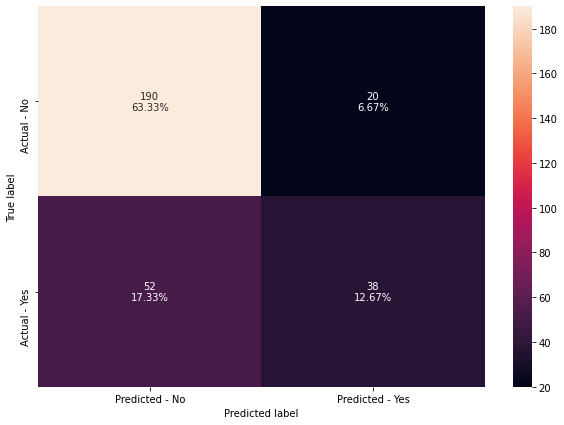

In [30]:
make_confusion_matrix(rf_estimator_tuned,y_test)

### Insights
- We can see that random forest's performance has increased as compared to the random forest model with default parameters.
- Model is slightly overfitting the data but not as much as the tuned bagging classifier.
- The test recall is still very low. This means that the model is not good at identifying defaulters which is our primary aim here.

### Let's try using class_weights for random forest:
- The model performance is not very good. This may be due to the fact that the classes are imbalanced with 70% non-defaulters and 30% defaulters. 

- We should make the model aware that the class of interest here is 'defaulters'.

- We can do so by passing the parameter `class_weights` available for random forest. This parameter is not available for the bagging classifier.

- class_weight specifies the weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one.

- We can choose class_weights={0:0.3,1:0.7} because that is the original imbalance in our data.

In [31]:
# Choose the type of classifier. 
rf_estimator_weighted = RandomForestClassifier(random_state=1)

# Grid of parameters to choose from
## add from article
parameters = {
    "class_weight": [{0: 0.3, 1: 0.7}],
    "n_estimators": [100,150,200,250],
    "min_samples_leaf": np.arange(5, 10),
    "max_features": np.arange(0.2, 0.7, 0.1),
    "max_samples": np.arange(0.3, 0.7, 0.1),
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(rf_estimator_weighted, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
rf_estimator_weighted = grid_obj.best_estimator_

# Fit the best algorithm to the data.
rf_estimator_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.3, 1: 0.7}, max_features=0.2,
                       max_samples=0.6000000000000001, min_samples_leaf=9,
                       n_estimators=150, random_state=1)

In [32]:
#Using above defined function to get accuracy, recall and precision on train and test set
rf_estimator_weighted_score=get_metrics_score(rf_estimator_weighted)

Accuracy on training set :  0.7957142857142857
Accuracy on test set :  0.7133333333333334
Recall on training set :  0.7904761904761904
Recall on test set :  0.6555555555555556
Precision on training set :  0.6264150943396226
Precision on test set :  0.5175438596491229


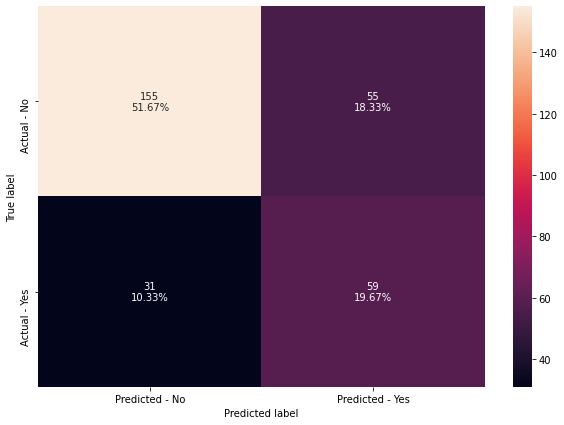

In [33]:
make_confusion_matrix(rf_estimator_weighted,y_test)

### Insights
- The model accuracy has decreased a bit but the overfitting has also been reduced and the model is generalizing well.
- The train and test recall both have increased significantly.
- We can see from the confusion matrix that the random forest model with class weights is now better at identifying the defaulters as compared to other models.

### Checking the feature importance

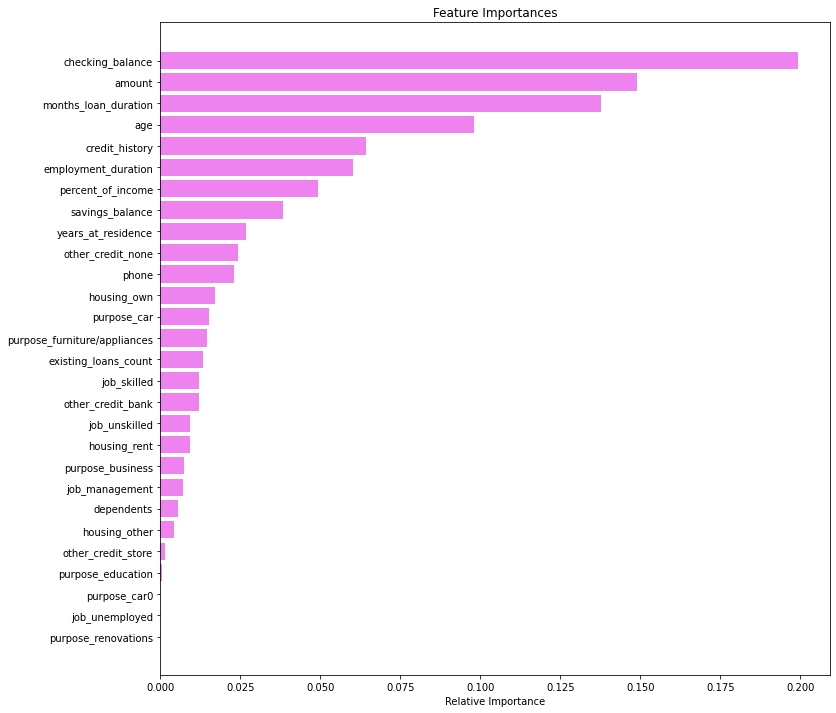

In [34]:
importances = rf_estimator_weighted.feature_importances_
indices = np.argsort(importances)
feature_names = list(X.columns)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

- Checking balance, amount and months loan duration are the top 3 features.

### Comparing all models till now

In [35]:
# defining list of models
models = [bagging_estimator,bagging_estimator_tuned,bagging_lr,rf_estimator,rf_estimator_tuned,
          rf_estimator_weighted]

# defining empty lists to add train and test results
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []

# looping through all the models to get the accuracy, precall and precision scores
for model in models:
    j = get_metrics_score(model,False)
    acc_train.append(np.round(j[0],2))
    acc_test.append(np.round(j[1],2))
    recall_train.append(np.round(j[2],2))
    recall_test.append(np.round(j[3],2))
    precision_train.append(np.round(j[4],2))
    precision_test.append(np.round(j[5],2))

In [36]:
comparison_frame = pd.DataFrame({'Model':['Bagging classifier with default parameters','Tuned Bagging Classifier',
                                        'Bagging classifier with base_estimator=LR', 'Random Forest with deafult parameters',
                                         'Tuned Random Forest Classifier','Random Forest with class_weights'], 
                                          'Train_Accuracy': acc_train,'Test_Accuracy': acc_test,
                                          'Train_Recall':recall_train,'Test_Recall':recall_test,
                                          'Train_Precision':precision_train,'Test_Precision':precision_test}) 
comparison_frame

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision
0,Bagging classifier with default parameters,0.98,0.74,0.94,0.48,0.99,0.59
1,Tuned Bagging Classifier,0.99,0.75,0.96,0.46,1.00,0.62
2,Bagging classifier with base_estimator=LR,0.74,0.72,0.33,0.36,0.62,0.54
3,Random Forest with deafult parameters,1.00,0.75,1.00,0.42,1.00,0.63
4,Tuned Random Forest Classifier,0.87,0.76,0.63,0.42,0.89,0.66
5,Random Forest with class_weights,0.80,0.71,0.79,0.66,0.63,0.52


### Note:
- Hyperparameter tuning is tricky and exhaustive in the sense that there is no direct way to calculate how a change in the
  hyperparameter value will reduce the loss of your model until you try those hyperparameters.
- The final results depend on the parameters used/checked using GridSearchCV.
- There may be yet better parameters which may result in a better accuracy and recall. Students can explore this further.